<a href="https://colab.research.google.com/github/DrAlexSanz/Amazon-reviews-dataset/blob/master/Sentiment_analysis_Amazon_reviews_NN_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is a quick notebook to perform binary classification on the amazon reviews dataset

### Idea of this notebook.

1. Get the data.
2. Combine it in one DF or vector or something.
3. Label encoding.
4. Tokenize.
5. Train/test split.
6. Model training and testing using a quick benchmark. Simple NN, RNN and LSTM as a test of what I can achieve with simple models.

In [1]:
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras import Sequential
from keras.layers import Input, Dense, Dropout, Embedding, Activation, RNN, LSTM, SimpleRNN
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers.experimental.preprocessing import TextVectorization
from keras.initializers import Constant
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the data and store positive and negative reviews

The data is in xml format. Read it with bs4.

The idea is to find all the reviews text. findAll finds the text and the tags and produces a soup object result. I want a string and then I'll split it and clean the "\n". This is the way to do things.

In [2]:
pos_reviews = BeautifulSoup(open("positive.review").read())
neg_reviews = BeautifulSoup(open("negative.review").read())

pos_list = []

pos_revs = pos_reviews.find_all("review_text")

for rev in pos_revs:
    pos_list.append(rev.text)
    

neg_list = []

neg_revs = neg_reviews.find_all("review_text")

for rev in neg_revs:
    neg_list.append(rev.text)


## Remove the \n characters.

### I have a list of strings, for each string I replace the \n with a blank space and then I strip the leading and trailing spaces. On pos_list I just replace the \n by an inexisting character. Both works, the inexisting character is probably better and more elegant but since I had to do the NLS at Cat I can also do it here ;)

In [3]:
clean_pos_list =[elem.replace("\n", "") for elem in pos_list]

clean_neg_list =[elem.replace("\n", " ").strip() for elem in neg_list]




### Out of curiosity, check how long are the reviews. Vaya tochos sin resumen. Es de vergüenza su actitud.

In [4]:
max_len = [len(elem) for elem in clean_pos_list]
longest = max(max_len)
print(longest)

max_len_neg = [len(elem) for elem in clean_neg_list]
print(max(max_len))

5840
5840


## Now I will tag the pos and negs myself. I don't need label encoding.
### Then union the two dataframes

In [5]:
pos = pd.DataFrame(clean_pos_list, columns = ["Reviews"])
pos["label"] = 1

neg = pd.DataFrame(clean_neg_list, columns = ["Reviews"])
neg["label"] = 0

dataset = pd.concat([pos, neg], ignore_index = True)

## It's probably not the best way to do this but I put the tags, concat both DFs and now I'll make two vectors and tokenize.

In [6]:
X = dataset["Reviews"]
y = dataset["label"]

y = y.values.tolist()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [8]:
print(x_test)

681     Great buy for a wonderful speaker system. Work...
1601    I bought these cables, brought them home and i...
819     I had a problem with my Sunrocket VOIP and I r...
910     I am extremely pleased with the purchase. I am...
330     I'm using this AP, along with a Netgear 802.11...
                              ...                        
1685    i was very disappointed with the ge superadio ...
152     PROS:smallreliablevery good quality with pictu...
351     I recently bought a new 6.0 megapixel digital ...
266     Myself and my grandchildren love to hold these...
1559    OK. I take my words back. I found a solution t...
Name: Reviews, Length: 400, dtype: object


In [9]:
# Convert y to np array

x_test = np.array(x_test)
x_train = np.array(x_train)

y_test = np.array(y_test)
y_train = np.array(y_train)

In [10]:
longest_train = max([len(i) for i in x_train])
max([len(i) for i in x_test])

5840

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-21 19:20:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-21 19:20:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-21 19:20:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [12]:
!unzip -q glove.6B.zip

Make a dictionary mapping words to word vectors (Numpy arrays)

In [13]:
embeddings_index = {}
with open("glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep = " ")
        embeddings_index[word] = coefs

print("Found %s word vectors" % len(embeddings_index))

Found 400000 word vectors


Let's vectorize the text

In [58]:
vectorizer = TextVectorization(max_tokens = 20000, output_sequence_length = 28)
vectorizer.adapt(x_train)

Now I want to see the vocab

In [59]:
vectorizer.get_vocabulary()[:13] #mostly stopwords

['',
 '[UNK]',
 'the',
 'i',
 'to',
 'and',
 'a',
 'it',
 'is',
 'of',
 'this',
 'for',
 'that']

I make a dictionary between indices and words.

In [60]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(2, len(voc))))

I want to have a mapping between words (strings) and glove vectors for later

In [61]:
embeddings_index = {}

with open("glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep = " ")
        embeddings_index[word] = coefs

print("Found %s word vectors" % len(embeddings_index))

Found 400000 word vectors


I'll transform x_train and x_test.

In [62]:
vec_train = vectorizer(np.array([[s] for s in x_train])).numpy()
vec_test = vectorizer(np.array([[s] for s in x_test])).numpy()

Now I prepare the embedding matrix for the embedding layer.

In [63]:
num_tokens = len(voc) + 2
embedding_dim = 100

hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # If the word is not in vocab I get only zeroes
        embedding_matrix[i] = embedding_vector
        hits += 1

    else:
        misses +=1

print("Converted %d words and missed %d" % (hits, misses))

Converted 8881 words and missed 2870


Now I can finally make an embedding layer:

In [64]:
embedding_layer = Embedding(input_dim = num_tokens, output_dim = embedding_dim,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)

### Up to here it was the same thing. Preprocessing is common, the ML/AI is the less relevant part.

#### Now I'll do three models. A dense and an RNN/LSTM one.

In [70]:
def plain():
    inputs = Input(name = "inputs", shape = 28)
    layer = Dense(units = 128)(inputs)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 64)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 32)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 16)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 8)(layer)
    layer = Activation("relu")(layer)
    layer = Dense(units = 1)(layer)
    output = Activation("sigmoid")(layer)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

### Now let's create the model and make a summary

In [71]:
plain_model = plain()

plain_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28)]              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               3712      
_________________________________________________________________
activation_32 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_33 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)              

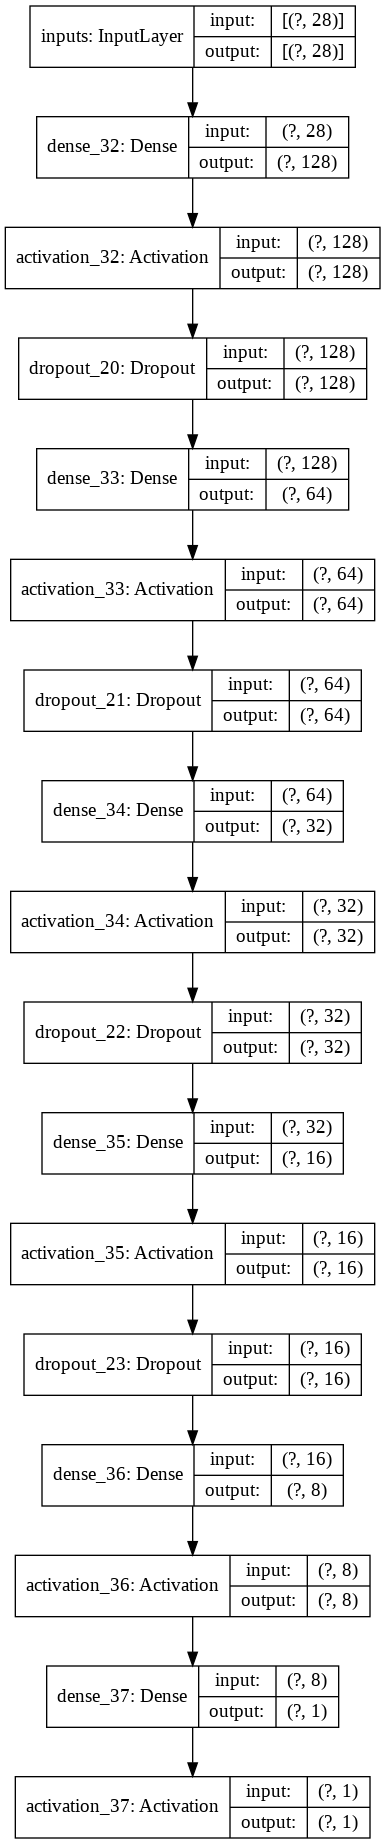

In [72]:
plot_model(plain_model, show_shapes = True, show_layer_names = True)

### There is probably going to be a crazy overfitting, but let's do it.

In [73]:
plain_model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = ["accuracy"])

#Uncomment for training

plain_model.fit(vec_train, y_train, batch_size = 128, epochs = 30, validation_split = 0.2)

Epoch 1/30
10/10 [==============================] - 0s 15ms/step - loss: 342.1767 - accuracy: 0.5117 - val_loss: 52.1505 - val_accuracy: 0.4656
Epoch 2/30
10/10 [==============================] - 0s 4ms/step - loss: 226.8225 - accuracy: 0.4961 - val_loss: 22.4864 - val_accuracy: 0.4906
Epoch 3/30
10/10 [==============================] - 0s 4ms/step - loss: 162.9054 - accuracy: 0.4844 - val_loss: 13.3064 - val_accuracy: 0.4688
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 112.5120 - accuracy: 0.5109 - val_loss: 8.6020 - val_accuracy: 0.4844
Epoch 5/30
10/10 [==============================] - 0s 4ms/step - loss: 103.8200 - accuracy: 0.4984 - val_loss: 6.7258 - val_accuracy: 0.4844
Epoch 6/30
10/10 [==============================] - 0s 4ms/step - loss: 85.7516 - accuracy: 0.4633 - val_loss: 4.7491 - val_accuracy: 0.4781
Epoch 7/30
10/10 [==============================] - 0s 4ms/step - loss: 67.1932 - accuracy: 0.4844 - val_loss: 3.2804 - val_accuracy: 0.4719
Epoc

## It didn't learn much. Probably it's just that the network is learning the logistic regression or something similar to that separation.

### Let's do an RNN and later an LSTM. I'm going make them overfit like crazy

In [90]:
def plain_RNN():
    inputs = Input(name = "inputs", shape = 28)
    layer = embedding_layer(inputs)
    layer = SimpleRNN(units = 64, activation = "relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 400, activation = "relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 40, activation = "relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 4, activation = "relu")(layer)
    layer = Dense(units = 1)(layer)
    output = Activation("sigmoid")(layer)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [91]:
rnn_model = plain_RNN()

rnn_model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28)]              0         
_________________________________________________________________
embedding_2 (Embedding)      multiple                  1175500   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 400)               26000     
_________________________________________________________________
dropout_33 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 40)              

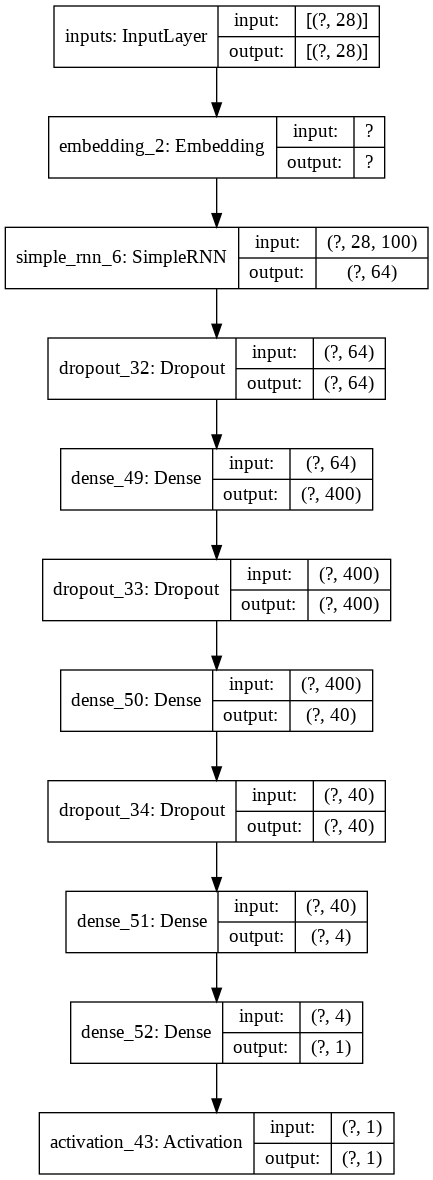

In [92]:
plot_model(rnn_model, show_shapes = True, show_layer_names = True, expand_nested = True)

In [93]:
rnn_model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = ["accuracy"])

#Uncomment for training

rnn_model.fit(vec_train, y_train, batch_size = 128, epochs = 50, validation_split = 0.2)

Epoch 1/50
10/10 [==============================] - 0s 31ms/step - loss: 0.7071 - accuracy: 0.4945 - val_loss: 0.6947 - val_accuracy: 0.4875
Epoch 2/50
10/10 [==============================] - 0s 14ms/step - loss: 0.6950 - accuracy: 0.5031 - val_loss: 0.6938 - val_accuracy: 0.4844
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.5164 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6934 - accuracy: 0.5086 - val_loss: 0.6929 - val_accuracy: 0.5094
Epoch 5/50
10/10 [==============================] - 0s 14ms/step - loss: 0.6919 - accuracy: 0.5227 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/50
10/10 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5234 - val_loss: 0.6928 - val_accuracy: 0.5031
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5203 - val_loss: 0.6925 - val_accuracy: 0.4938
Epoch 8/50
10

In [86]:
def LSTM_RNN():
    inputs = Input(name = "inputs", shape = 28)
    layer = embedding_layer(inputs)
    layer = LSTM(units = 52)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 200)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 100)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 10)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 1)(layer)
    output = Activation("sigmoid")(layer)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [87]:
LSTM_model = LSTM_RNN()

LSTM_model.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28)]              0         
_________________________________________________________________
embedding_2 (Embedding)      multiple                  1175500   
_________________________________________________________________
lstm_3 (LSTM)                (None, 52)                31824     
_________________________________________________________________
dropout_28 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 200)               10600     
_________________________________________________________________
dropout_29 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 100)             

In [89]:
LSTM_model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = ["accuracy"])

#Uncomment for training

LSTM_model.fit(vec_train, y_train, batch_size = 128, epochs = 50, validation_split = 0.2)

Epoch 1/50
10/10 [==============================] - 0s 42ms/step - loss: 0.6031 - accuracy: 0.6672 - val_loss: 0.7283 - val_accuracy: 0.5250
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 0.5963 - accuracy: 0.6687 - val_loss: 0.7484 - val_accuracy: 0.5094
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 0.5863 - accuracy: 0.6836 - val_loss: 0.7375 - val_accuracy: 0.5469
Epoch 4/50
10/10 [==============================] - 0s 6ms/step - loss: 0.5965 - accuracy: 0.6867 - val_loss: 0.7576 - val_accuracy: 0.5125
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 0.5767 - accuracy: 0.6781 - val_loss: 0.7405 - val_accuracy: 0.5625
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 0.5643 - accuracy: 0.7203 - val_loss: 0.7640 - val_accuracy: 0.5656
Epoch 7/50
10/10 [==============================] - 0s 7ms/step - loss: 0.5550 - accuracy: 0.7234 - val_loss: 0.7767 - val_accuracy: 0.5688
Epoch 8/50
10/10 [=